## Extractive Summarization

In this notebook, we provide an implementation for training an extractive text summarization model. The overall goal is to "score" each sentence in a passage where the score represents the likelihood that the sentence belongs in a summary.


## Dataset

We will use the CNN/Dailymail dataset (contains articles and human written highlights) which has been preprocessed in the following way

- Each sentence in each article (extracted using a large Spacy LM) is assigned a label (0: not in summary, 1: in summary). Since CNN/DailyMail highlights dont contain exact extracts, the label is generatedd based on max Rogue score between sentence and each sentence in highlights. See data preprocesssing notebook for details.
- Data is undersampled to reduce class imbalance 

## Problem Formulation and Model 

We treat this as a sentence classification problem where the goal is to classify each sentence in a document as belonging to a summary or not, given the document (or portions of the document) 

- Input: a sentence, and the entire document 
- Output: A score representing likelihood of belonging in the summary or not. 

## Implementation 

- We use sentence bert models to get representations for our text. We use the smallest model (sentence-transformers/paraphrase-MiniLM-L3-v2), but this can be replaced by a larger more accurate model. See the list of sentence bert pretrained  [models](https://www.sbert.net/docs/pretrained_models.html#sentence-embedding-models).
- Representations for sentence and document are concatenated and fed to a Dense layer and then predictions.

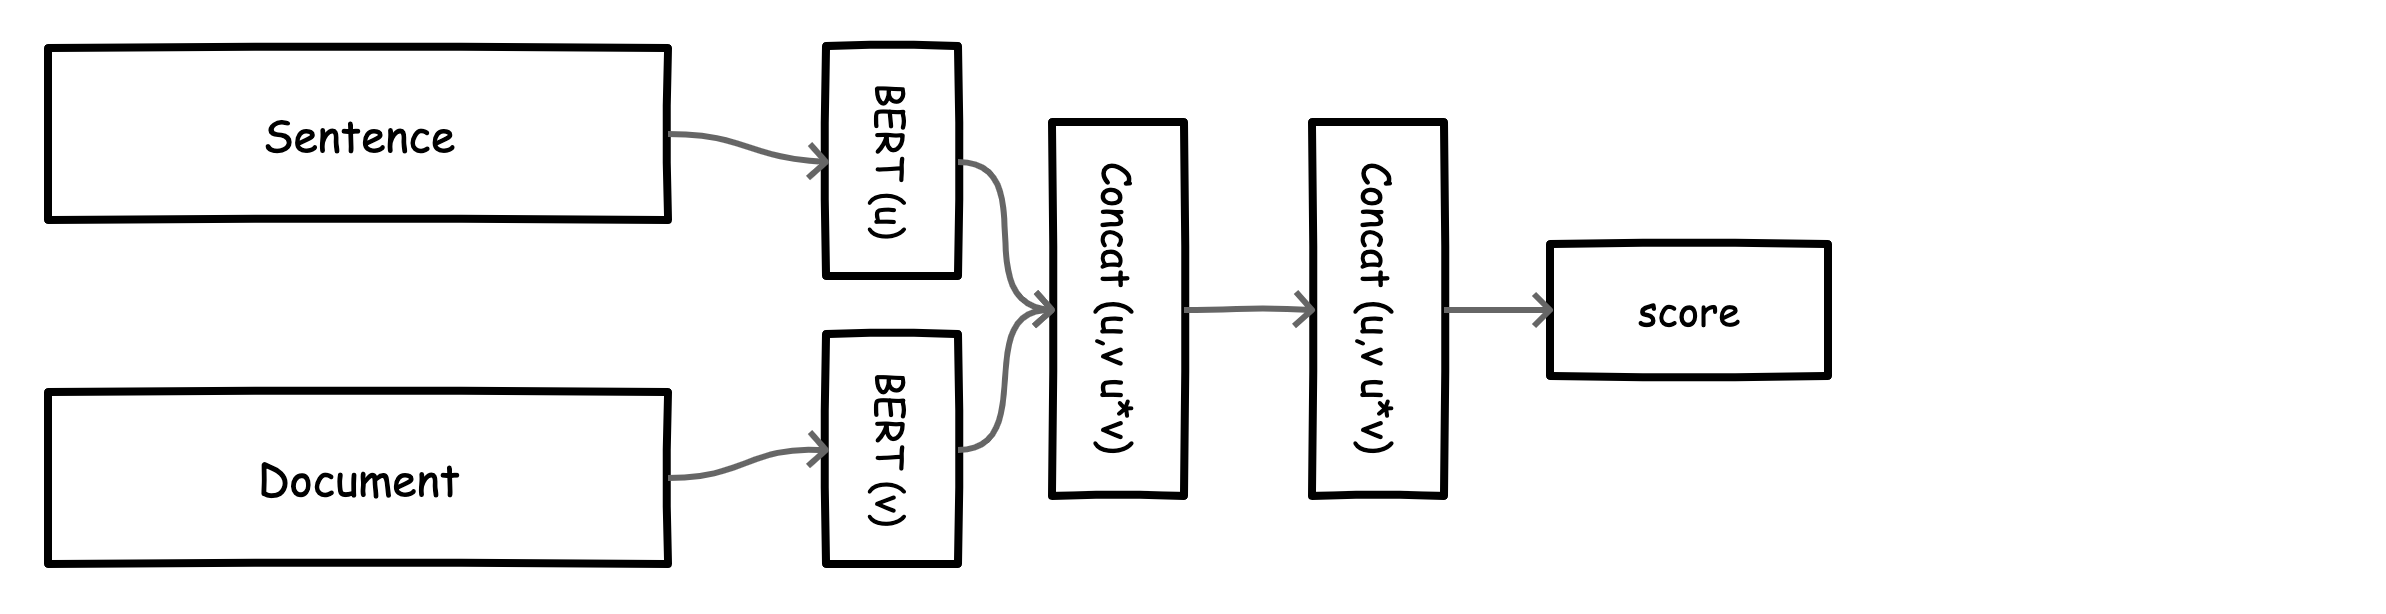

In [1]:
!pip install -q transformers  rouge-score  

     |████████████████████████████████| 2.6 MB 8.5 MB/s 
     |████████████████████████████████| 636 kB 59.0 MB/s 
     |████████████████████████████████| 895 kB 75.7 MB/s 
     |████████████████████████████████| 3.3 MB 57.5 MB/s 


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
 
import pandas as pd 
import transformers
from torch.utils.data import Dataset, DataLoader 


from transformers import AutoTokenizer, AutoModel
sentenc_model_name = "sentence-transformers/paraphrase-MiniLM-L3-v2"
tokenizer = AutoTokenizer.from_pretrained(sentenc_model_name) 


Downloading:   0%|          | 0.00/516 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [3]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from tqdm.notebook import tqdm
 
import os 
  
sum_dir = "drive/MyDrive/mlexperiments/extractivesummarization/" # location to store and load models 

In [6]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 1
LEARNING_RATE = 1e-05 

# load dataframes containining preprocessed samples from CNN/Dailymail Dataset
train_df = pd.read_json(sum_dir + "data/train_bdf.json")
test_df = pd.read_json(sum_dir +"data/test_bdf.json") 
print( "Train, test shape", train_df.shape, test_df.shape)

Train, test shape (4308, 3) (1080, 3)


## Create a Data Loader Class 

- Create a dataloader class that yields sentences and documentss and labels.

In [8]:

# Create a Data Loader Class
class CNNDailyMailData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        sentence = str(self.data.iloc[index].sents)
        sentence = " ".join(sentence.split())

        document = str(self.data.iloc[index].docs)
        document = " ".join(document.split())

        inputs = self.tokenizer.batch_encode_plus(
            [sentence, document], 
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'sent_ids': torch.tensor(ids[0], dtype=torch.long),
            'doc_ids': torch.tensor(ids[1], dtype=torch.long),
            'sent_mask': torch.tensor(mask[0], dtype=torch.long),
            'doc_mask': torch.tensor(mask[1], dtype=torch.long),
            'targets': torch.tensor([self.data.iloc[index].y], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len



training_set = CNNDailyMailData(train_df, tokenizer, MAX_LEN)
testing_set = CNNDailyMailData(test_df, tokenizer, MAX_LEN)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)        

## Build Model 

- Build model based on sentence Bert pretrained models.

In [9]:
# get mean pooling for sentence bert models 
# ref https://www.sbert.net/examples/applications/computing-embeddings/README.html#sentence-embeddings-with-transformers
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class SentenceBertClass(torch.nn.Module):
    def __init__(self, model_name="sentence-transformers/paraphrase-MiniLM-L3-v2"):
        super(SentenceBertClass, self).__init__()
        self.l1 = AutoModel.from_pretrained(model_name)
        self.pre_classifier = torch.nn.Linear(384*3, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 1)
        self.classifierSigmoid = torch.nn.Sigmoid()

    def forward(self, sent_ids, doc_ids, sent_mask, doc_mask):

        sent_output = self.l1(input_ids=sent_ids, attention_mask=sent_mask) 
        sentence_embeddings = mean_pooling(sent_output, sent_mask) 

        doc_output = self.l1(input_ids=doc_ids, attention_mask=doc_mask) 
        doc_embeddings = mean_pooling(doc_output, doc_mask)

        # elementwise product of sentence embs and doc embs
        combined_features = sentence_embeddings * doc_embeddings  

        # get concat of both features and elementwise product
        feat_cat = torch.cat((sentence_embeddings, doc_embeddings, combined_features), dim=1)  
        
        pooler = self.pre_classifier(feat_cat) 
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.classifierSigmoid(output) 

        return output

In [40]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

model = SentenceBertClass(model_name=sentenc_model_name)
model.to(device);

loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [46]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model
print_n_steps = 100
EPOCHS = 3 
acc_step_holder, loss_step_holder = [], []


def train(epoch):    
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        sent_ids = data['sent_ids'].to(device, dtype = torch.long)
        doc_ids = data['doc_ids'].to(device, dtype = torch.long)
        sent_mask = data['sent_mask'].to(device, dtype = torch.long)
        doc_mask = data['doc_mask'].to(device, dtype = torch.long) 
        targets = data['targets'].to(device, dtype = torch.float)  

        outputs = model(sent_ids, doc_ids, sent_mask, doc_mask) 
        loss = loss_function(outputs, targets)
        tr_loss += loss.item() 
        n_correct += torch.count_nonzero(targets == (outputs > 0.5)).item()

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%print_n_steps==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(str(_* train_params["batch_size"]) + "/" + str(len(train_df)) + " - Steps. Acc ->", accu_step, "Loss ->", loss_step)
            acc_step_holder.append(accu_step), loss_step_holder.append(loss_step)
        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [47]:
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]

0/4308 - Steps. Acc -> 50.0 Loss -> 0.6884710192680359
400/4308 - Steps. Acc -> 76.23762376237623 Loss -> 0.5120698381768595
800/4308 - Steps. Acc -> 75.74626865671642 Loss -> 0.5173890027240734
1200/4308 - Steps. Acc -> 77.07641196013289 Loss -> 0.5033040077880372
1600/4308 - Steps. Acc -> 76.55860349127182 Loss -> 0.5040610237163201
2000/4308 - Steps. Acc -> 76.24750499001996 Loss -> 0.5047704504427319
2400/4308 - Steps. Acc -> 76.66389351081531 Loss -> 0.4958293236011078
2800/4308 - Steps. Acc -> 76.53352353780313 Loss -> 0.49851657326908494
3200/4308 - Steps. Acc -> 76.68539325842697 Loss -> 0.49552774536289673
3600/4308 - Steps. Acc -> 76.99778024417314 Loss -> 0.48977874146648304
4000/4308 - Steps. Acc -> 76.998001998002 Loss -> 0.486618684267962
The Total Accuracy for Epoch 0: 77.15877437325905
Training Loss Epoch: 0.4864068306020929
Training Accuracy Epoch: 77.15877437325905


0it [00:00, ?it/s]

0/4308 - Steps. Acc -> 100.0 Loss -> 0.49371153116226196
400/4308 - Steps. Acc -> 80.94059405940594 Loss -> 0.4329431925964828
800/4308 - Steps. Acc -> 80.4726368159204 Loss -> 0.43122320092139554
1200/4308 - Steps. Acc -> 81.56146179401993 Loss -> 0.42087980889501764
1600/4308 - Steps. Acc -> 81.73316708229426 Loss -> 0.41441600914682236
2000/4308 - Steps. Acc -> 82.13572854291417 Loss -> 0.40610162577705233
2400/4308 - Steps. Acc -> 81.78036605657238 Loss -> 0.4081623741424024
2800/4308 - Steps. Acc -> 81.45506419400856 Loss -> 0.4127474235006729
3200/4308 - Steps. Acc -> 81.74157303370787 Loss -> 0.4046301527574342
3600/4308 - Steps. Acc -> 82.13096559378468 Loss -> 0.39985277560786586
4000/4308 - Steps. Acc -> 82.21778221778222 Loss -> 0.39779524373394864
The Total Accuracy for Epoch 1: 82.10306406685237
Training Loss Epoch: 0.3986765888961466
Training Accuracy Epoch: 82.10306406685237


0it [00:00, ?it/s]

0/4308 - Steps. Acc -> 50.0 Loss -> 0.46006760001182556
400/4308 - Steps. Acc -> 86.88118811881188 Loss -> 0.31923153539105215
800/4308 - Steps. Acc -> 84.45273631840796 Loss -> 0.36348400937754716
1200/4308 - Steps. Acc -> 85.6312292358804 Loss -> 0.3469914162525307
1600/4308 - Steps. Acc -> 85.97256857855362 Loss -> 0.33929044973486083
2000/4308 - Steps. Acc -> 86.57684630738522 Loss -> 0.32787533643508626
2400/4308 - Steps. Acc -> 86.85524126455907 Loss -> 0.31835872869932413
2800/4308 - Steps. Acc -> 86.84022824536376 Loss -> 0.31803361127968777
3200/4308 - Steps. Acc -> 86.70411985018727 Loss -> 0.31978582140388484
3600/4308 - Steps. Acc -> 86.70921198668147 Loss -> 0.32114137924761077
4000/4308 - Steps. Acc -> 86.91308691308691 Loss -> 0.3164656404536087
The Total Accuracy for Epoch 2: 86.86165273909006
Training Loss Epoch: 0.3206027058249784
Training Accuracy Epoch: 86.86165273909006


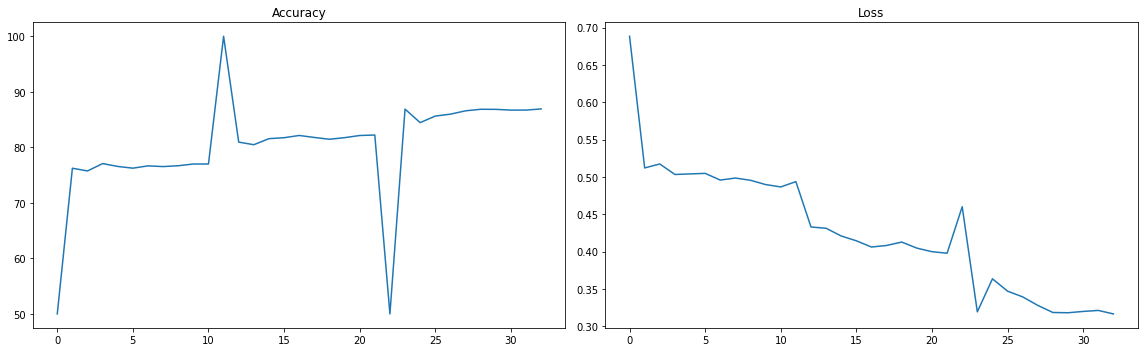

In [48]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
ax1.plot(acc_step_holder, label="Accuracy")
ax2.plot(loss_step_holder, label="Loss")
ax1.title.set_text("Accuracy")
ax2.title.set_text("Loss")
fig.tight_layout()
plt.show()

## Validation on Test Set

In [49]:
def validate_model(model, testing_loader):
    model.eval()

    n_correct = 0; n_wrong = 0; total = 0;  tr_loss = 0; nb_tr_steps = 0 ; nb_tr_examples = 0;
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0): 
            
            sent_ids = data['sent_ids'].to(device, dtype = torch.long)
            doc_ids = data['doc_ids'].to(device, dtype = torch.long)
            sent_mask = data['sent_mask'].to(device, dtype = torch.long)
            doc_mask = data['doc_mask'].to(device, dtype = torch.long) 
            targets = data['targets'].to(device, dtype = torch.float)  

            outputs = model(sent_ids, doc_ids, sent_mask, doc_mask) 
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            
            n_correct += torch.count_nonzero(targets == (outputs > 0.5)).item()

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%print_n_steps==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples 
                print(str(_* test_params["batch_size"]) + "/" + str(len(train_df)) + " - Steps. Acc ->", accu_step, "Loss ->", loss_step)

             
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu


In [50]:
acc = validate_model(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

0/4308 - Steps. Acc -> 50.0 Loss -> 0.6739829778671265
200/4308 - Steps. Acc -> 71.78217821782178 Loss -> 0.6601082288687772
400/4308 - Steps. Acc -> 70.64676616915423 Loss -> 0.6567564338204724
600/4308 - Steps. Acc -> 69.60132890365449 Loss -> 0.6828461873509064
800/4308 - Steps. Acc -> 70.94763092269326 Loss -> 0.6389451671572881
1000/4308 - Steps. Acc -> 71.55688622754491 Loss -> 0.6253459133531252
Validation Loss Epoch: 0.6105277952600132
Validation Accuracy Epoch: 72.4074074074074
Accuracy on test data = 72.41%


Hint: Try a larger sentence embedding [pretrained model](https://www.sbert.net/docs/pretrained_models.html#sentence-embedding-models) to improve overall train/test accuracy. 

## Save Model

In [51]:
import os 

os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/minilm_bal_exsum.pth")
!gsutil cp -r models $sum_dir

Copying file://models/minilm_bal_exsum.pth...
/ [1 files][ 69.7 MiB/ 69.7 MiB]                                                
Operation completed over 1 objects/69.7 MiB.                                     


# Conclusions 

- We trained a baseline model that achieves some accuracy using a sentence Bert model  on the task of extractive text summarization. 
- Potential Next steps?
  - Use a larger sentence BERT model 
  - Train on more data 
  - Explore other approaches for addressing data imbalance. In this example we undersampled the majority class in our data preprocessing script. The drawback is that we use only a *small* amount of total available data. We can use other approaches such as a weighted loss functions that allows us use the entire dataset.
  - Explore other formulations of the problem. In our implementation we assign a label (0/1) based on the max Rouge score between each sentence and sentences in the ground truth highlights and a threshold ( label = max_score > threshold 1 else 0). We can tune this threshold, or use the Rouge score directly. 
  - Tune hyper parameters. We can tune model hyper parameters and also data preprocessing hyperparameters (e.g. minimum sentence length, relevance scoring algorithm etc).